### Link to the kaggle : https://www.kaggle.com/kvpratama/pokemon-images-dataset

##### The aim of the project is to create a new pokemon based on the "real" ones (those created by Nintendo)
##### To do that, we will have to use a GAN (Generate Adversarial Network)

# Import

In [1]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torch import nn, optim

import warnings
warnings.filterwarnings('ignore')

# Test with one picture

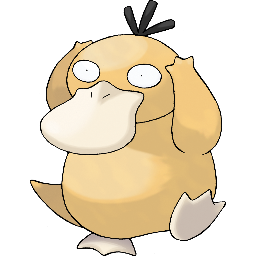

In [2]:
display.Image('data/all/pokemon/54.png')

# Code using torch

## Creating the DataLoader

In [3]:
# Resize : Resize the image to the given size (as a parameter)
# CenterCrop : Crop the image at the center, the parameter is the size of the crop
# ToTensor : Convert an Image (or PIL Image) to a numpy.array
# Normalize : Normalize a tensor using (mean, stand deviation) as parameters

In [4]:
def create_trainloader(path, size, batch):

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.ImageFolder(root = path, transform = transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch, shuffle = True, num_workers = 2)

    return trainloader

## Showing some Pokemon

In [5]:
def reshape_for_graph(images, means, std):
    
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return (images * std + means)

In [6]:
def show_some_pokemon(dataset, nb_pokemon, nb_rows):
    
    for images, labels in dataset: 
        fig, ax = plt.subplots(figsize = (15, 15))
        reshaped =  reshape_for_graph(images, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ax.imshow(make_grid(reshaped[:nb_pokemon], nrow = nb_rows).permute(1, 2, 0).clamp(0, 1))
        break

## Doing the GAN (Generative Adversarial Networks)

#### GAN use two sub-models to work : a Generator and a Discriminator
#### Basically, the Generator has to generate fake pictures while the Discriminator has to determine if a picture if a real one or a fake

In [7]:
def init_weights(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

##### The aim of the Generator can be summed up with this picture :
![Generator Model (in folder "images")](images/generator.png)

In [8]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )



    def forward(self, input):

        return self.main(input)

##### The aim of the Discriminator can be summed up with this picture :
![Discriminator Model (in folder "images")](images/discriminator.png)

In [9]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )




    def forward(self, input):
        
        return self.main(input)

In [10]:
def create_generator():
    
    generator = Generator()
    generator.to('cpu')
    generator.apply(init_weights)

    return generator

In [11]:
def create_discriminator():
    
    discriminator = Discriminator()
    discriminator.to('cpu')
    discriminator.apply(init_weights)

    return discriminator

##### We start the machine learning

In [12]:
def machine_learning(trainloader, generator, discriminator, epochs):

    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, 100, 1, 1, device = 'cpu')

    real_label = 1.
    fake_label = 0.

    optimizer_gen = optim.Adam(generator.parameters(), lr = 0.0001, betas=(0.5, 0.999))
    optimizer_dis = optim.Adam(discriminator.parameters(), lr = 0.0001, betas=(0.5, 0.999))

    images = []
    gen_losses, dis_losses = [], []
    total = 0

    for epoch in range(epochs):
        gen_loss, dis_loss = 0.0, 0.0
        D_x, D_G_z1, D_G_z2 = 0.0, 0.0, 0.0

        for i, data in enumerate(trainloader, 0):

            discriminator.zero_grad()
            real_cpu = data[0].to('cpu')
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype = torch.float, device = 'cpu')
            output = discriminator(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x += output.mean().item()

            noise = torch.randn(b_size, 100, 1, 1, device = 'cpu')
            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 += output.mean().item()
            errD = errD_real + errD_fake
            optimizer_dis.step()


            generator.zero_grad()
            label.fill_(real_label)
            output = discriminator(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 += output.mean().item()
            optimizer_gen.step()
            

            gen_loss += errG.item()
            dis_loss += errD.item()
            total += b_size
        



        # END OF THE FOR LOOP IN THE FOR LOOP



            
        avg_g_loss = gen_loss / total
        gen_losses.append(avg_g_loss)
        avg_d_loss = dis_loss / total
        dis_losses.append(avg_d_loss)
        
        avg_D_x = D_x / len(trainloader)
        avg_D_G_z1 = D_G_z1 / len(trainloader)
        avg_D_G_z2 = D_G_z2 / len(trainloader)    

        print('Epoch: {} / {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f}'.format(
            epoch + 1,
            epochs,
            avg_d_loss,
            avg_g_loss,
            avg_D_x,
            (avg_D_G_z1 / avg_D_G_z2)
        ))
        
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        images.append(make_grid(reshape_for_graph(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), padding = 2, normalize=True))

    losses = [gen_losses, dis_losses]

    return generator, discriminator, images, losses

## Plot of the losses

In [13]:
def show_losses(gen_losses, dis_losses):
    
    plt.figure(figsize = (15, 15))
    plt.plot(gen_losses, label = "Generator")
    plt.plot(dis_losses, label = "Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Saving the models when we are satisfied with them

https://pytorch.org/tutorials/beginner/saving_loading_models.html

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [14]:
def save_gen(generator, path):
    
    torch.save(generator.state_dict(), path)

In [15]:
def save_dis(discriminator, path):
    
    torch.save(discriminator.state_dict(), path)

In [16]:
def load_gen(path, type):
    
    model_load_G = Generator()
    model_load_G.load_state_dict(torch.load(path + type + '.pth'))
    
    return model_load_G

In [17]:
def load_dis(path, type):
    
    model_load_D = Discriminator()
    model_load_D.load_state_dict(torch.load(path + type + '.pth'))
    
    return model_load_D

In [18]:
def fakemons(generator):
    fixed_noise = torch.randn(64, 100, 1, 1, device = 'cpu')
    images = []

    for i in range(3):
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        images.append(torchvision.utils.make_grid(reshape_for_graph(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), padding = 2, normalize = True))
    
    return images